In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_bagerhat = pd.read_csv('Bagerhat_historical_weather_1980_2024.csv')

# for Heatstroke

here we are taking temperature and humidity so that data doesn't leak while training models

In [5]:
df_bagerhat.info()
df_bagerhat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16437 entries, 0 to 16436
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   district                       16437 non-null  object 
 1   day                            16437 non-null  int64  
 2   month                          16437 non-null  int64  
 3   year                           16437 non-null  int64  
 4   temperature(degree C)          10478 non-null  float64
 5   feels_like(degree C)           10478 non-null  float64
 6   max_temperature(degree C)      14991 non-null  float64
 7   minimum_temperature(degree C)  14991 non-null  float64
 8   humidity                       10478 non-null  float64
 9   precipitation                  5479 non-null   float64
 10  windspeed                      11924 non-null  float64
 11  atmospheric_pressure           7115 non-null   float64
 12  UV                             4038 non-null  

,district,day,month,year,temperature(degree C),feels_like(degree C),max_temperature(degree C),minimum_temperature(degree C),humidity,precipitation,windspeed,atmospheric_pressure,UV,solar_radiation,dew_point
0,Bagerhat,1,1,1980,21.7,21.7,26.1,18.1,77.1,NaN,3.6,1013.0,NaN,NaN,17.1
1,Bagerhat,2,1,1980,20.8,20.8,25.1,15.1,64.4,NaN,5.4,1012.9,NaN,NaN,13.3
2,Bagerhat,3,1,1980,23.0,23.0,26.1,16.6,60.2,NaN,16.6,1013.0,NaN,NaN,14.1
3,Bagerhat,4,1,1980,22.3,22.3,26.1,16.1,70.4,NaN,18.4,1014.2,NaN,NaN,16.3
4,Bagerhat,5,1,1980,22.1,22.1,26.1,18.1,67.8,NaN,11.2,1015.1,NaN,NaN,15.5


 # find the number of datasets for temperature and humidity in the dataset

In [6]:
# find the number of temperature and humidity in the dataset
df_bagerhat_temperature= df_bagerhat['temperature(degree C)'].count()
print (f"temperature(degree C) has : {df_bagerhat_temperature}")

df_bagerhat_humidity= df_bagerhat['humidity'].count()
print (f"humidity has : {df_bagerhat_humidity}")

temperature(degree C) has : 10478
humidity has : 10478


# Features for HeatStroke

We need several parameters for heatstroke ( including HI and wet bulb) , but we will nly use temperature and humidity to avoid leakage 

In [7]:
desired_cols_hs = [
    'day', 'month', 'year',
    'temperature(degree C)',  # Core metric
    'humidity'                 # Core metric
]
HS_df_bagerhat = df_bagerhat[desired_cols_hs].copy()
no_null_HS= HS_df_bagerhat.dropna()
print(f"After removing missing values from bagerhat, dataset contains {no_null_HS.shape[0]} rows and {no_null_HS.shape[1]} columns out of {df_bagerhat.shape[0]} rows.")
no_null_HS.tail(20)


After removing missing values from bagerhat, dataset contains 10478 rows and 5 columns out of 16437 rows.


,day,month,year,temperature(degree C),humidity
16417,12,12,2024,17.4,80.3
16418,13,12,2024,17.8,81.9
16419,14,12,2024,18.0,77.0
16420,15,12,2024,17.9,77.4
16421,16,12,2024,18.3,77.9
16422,17,12,2024,20.2,74.8
16423,18,12,2024,21.1,73.4
16424,19,12,2024,19.7,79.0
16425,20,12,2024,19.8,78.6
16426,21,12,2024,19.6,88.3


# count zero and drop

In [8]:

# count zeros per column and show as a table
zeros_per_col = (no_null_HS == 0).sum()
zeros_df = zeros_per_col.to_frame(name='zero_count')
zeros_df['zero_percentage'] = (zeros_df['zero_count'] / len(no_null_HS) * 100).round(2)
zeros_df = zeros_df[zeros_df['zero_count'] > 0].sort_values('zero_count', ascending=False)

print("Number of zeros per column (only columns with >0 zeros shown):")
display(zeros_df)

# drop rows that contain any 0 or 0.0 and update no_null_HS
rows_before = no_null_HS.shape[0]
no_null_HS = no_null_HS[(no_null_HS != 0).all(axis=1)]
rows_after = no_null_HS.shape[0]
print(f"Dropped {rows_before - rows_after} rows containing zero values. New shape: {no_null_HS.shape}")

Number of zeros per column (only columns with >0 zeros shown):


,zero_count,zero_percentage


Dropped 0 rows containing zero values. New shape: (10478, 5)


In [20]:
# ===== SETUP =====
temp_col = 'temperature(degree C)'
hum_col = 'humidity'

df = no_null_HS.copy()
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

# ===== 1) HEAT INDEX FUNCTION =====
def calculate_heat_index(temperature_c, humidity):
    """Calculate heat index from temperature (°C) and humidity (%)."""
    t_c = float(temperature_c)
    h = float(humidity)
    
    if 0.0 <= h <= 1.0:
        h = h * 100.0
    
    t_f = t_c * 9.0/5.0 + 32.0
    hi = 0.5 * (t_f + 61.0 + ((t_f - 68.0) * 1.2) + (h * 0.094))
    
    if hi >= 80.0:
        T = t_f
        R = h
        hi = (-42.379 + 2.04901523 * T + 10.14333127 * R
              - 0.22475541 * T * R - 6.83783e-3 * T**2
              - 5.481717e-2 * R**2 + 1.22874e-3 * T**2 * R
              + 8.5282e-4 * T * R**2 - 1.99e-6 * T**2 * R**2)
    
    hi_c = (hi - 32.0) * 5.0/9.0
    return hi_c

df['heat_index_C'] = df.apply(
    lambda r: calculate_heat_index(r[temp_col], r[hum_col]), axis=1)
df['heat_index_F'] = df['heat_index_C'] * 9.0/5.0 + 32.0

# ===== 2) WET-BULB TEMPERATURE =====
def wet_bulb_temp_C(T_c, RH):
    """Calculate wet-bulb temperature (Stull approximation)."""
    T = float(T_c)
    R = float(RH)
    Tw = T * np.arctan(0.151977 * np.sqrt(R + 8.313659)) \
         + np.arctan(T + R) - np.arctan(R - 1.676331) \
         + 0.00391838 * (R ** 1.5) * np.arctan(0.023101 * R) \
         - 4.686035
    return Tw

df['wet_bulb_C'] = df.apply(
    lambda r: wet_bulb_temp_C(r[temp_col], r[hum_col]), axis=1)

# ===== 3) DURATION FEATURES (Rolling windows) =====
df['hi_high_flag'] = (df['heat_index_F'] >= 105.0).astype(int)
df['hi_extreme_flag'] = (df['heat_index_F'] >= 129.0).astype(int)
df['hi_high_3day_count'] = df['hi_high_flag'].rolling(window=3, min_periods=1).sum()
df['hi_high_7day_count'] = df['hi_high_flag'].rolling(window=7, min_periods=1).sum()

# ===== 4) SEASONAL FEATURES =====
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear

# ===== 5) TEMPERATURE TREND =====
df['temp_change'] = df[temp_col].diff().fillna(0)

# ===== 6) HEATSTROKE SEVERITY CATEGORIZATION (Reference Only) =====
def categorize_heatstroke_severity(hi_f, tw_c):
    """Categorize heatstroke risk based on Heat Index (°F) and Wet-Bulb (°C)."""
    if hi_f >= 129.0 or tw_c >= 35.0:
        return 'Extreme Danger'
    if hi_f >= 105.0 or tw_c >= 30.0:
        return 'Danger'
    if hi_f >= 89.6:
        return 'Extreme Caution'
    if hi_f >= 80.6:
        return 'Caution'
    return 'Comfortable'

df['Heat_Severity'] = df.apply(
    lambda r: categorize_heatstroke_severity(r['heat_index_F'], r['wet_bulb_C']), axis=1)

# ===== 7) PROBABILISTIC HEATSTROKE RISK TARGET (NEW) =====
# Based on: HI thresholds + Wet-Bulb thresholds + Duration
# Returns: 0 (safe) to 1 (critical heatstroke risk)
def calculate_heatstroke_risk_prob(row):
    """
    Probabilistic risk combines HI thresholds + Tw thresholds + duration.
    
    Heatstroke occurs when:
    - HI > 105°F = high risk
    - HI > 129°F = extreme risk
    - Tw > 30°C = physiological stress (body can't cool effectively)
    - Tw > 35°C = extreme danger (body thermoregulation fails)
    - Multi-day exposure = accumulated fatigue
    """
    hi_f = row['heat_index_F']
    tw_c = row['wet_bulb_C']
    duration_3day = row['hi_high_3day_count']
    
    # --- BASE RISK FROM HEAT INDEX ---
    if hi_f >= 129.0:
        base_risk = 0.85  # Extreme HI: very high heatstroke risk
    elif hi_f >= 105.0:
        base_risk = 0.60  # High HI: substantial risk
    elif hi_f >= 89.6:
        base_risk = 0.35  # Caution level
    elif hi_f >= 80.6:
        base_risk = 0.15  # Low risk
    else:
        base_risk = 0.05  # Comfortable
    
    # --- ESCALATE BASED ON WET-BULB (Physiological limit) ---
    # Wet-bulb is more critical for heatstroke because it indicates
    # the body's ability to cool via evaporative sweating
    if tw_c >= 35.0:
        base_risk = max(base_risk, 0.90)  # Body can't cool = CRITICAL
    elif tw_c >= 30.0:
        base_risk = max(base_risk, 0.70)  # Significant thermoregulation strain
    
    # --- FURTHER ESCALATE BASED ON DURATION (Accumulated exposure) ---
    # 2+ consecutive days of HI >= 105°F = body already fatigued
    if duration_3day >= 2:
        base_risk = min(base_risk * 1.3, 1.0)  # Boost by 30%, cap at 1.0
    
    return base_risk

df['heatstroke_risk_prob'] = df.apply(calculate_heatstroke_risk_prob, axis=1)

# ===== 8) FINAL FEATURE SETS FOR MODELING =====
# For MODEL INPUT: use DERIVED features (HI, Tw, duration)
# These capture heatstroke risk better than raw T+RH
model_features = [
    'heat_index_F',           # Direct HI indicator (105°F = high risk)
    'wet_bulb_C',            # Physiological stress (30°C = risk threshold)
    'hi_high_3day_count',    # Duration of sustained heat (KEY for heatstroke)
    'month',                 # Seasonality/acclimatization
    'temp_change'            # Sudden temp spikes increase risk
]

# All features for reference/interpretation:
all_features = [
    'temperature(degree C)',      # Base input
    'humidity',                   # Base input
    'heat_index_F',              # Derived: combined heat stress
    'wet_bulb_C',                # Derived: physiological stress
    'hi_high_3day_count',        # Duration: 3-day sustained exposure
    'hi_high_7day_count',        # Duration: 7-day sustained exposure
    'month',                     # Seasonal: acclimatization varies
    'day_of_year',               # Annual: yearly cycle
    'temp_change',               # Trend: rate of change (sudden spikes matter)
    'Heat_Severity',             # Categorical label (reference)
    'heatstroke_risk_prob'       # TARGET: probabilistic risk (0-1)
]

print("=" * 80)
print(" HEATSTROKE RISK FEATURE ENGINEERING COMPLETE")
print("=" * 80)
print(f"\nDataFrame shape: {df.shape}")
print(f"\n MODEL INPUT FEATURES (for training):")
for i, feat in enumerate(model_features, 1):
    print(f"  {i}. {feat}")

print(f"\n TARGET VARIABLE:")
print(f"  - heatstroke_risk_prob (0.0 = safe, 1.0 = critical risk)")

print(f"\ ALL AVAILABLE FEATURES:")
for i, feat in enumerate(all_features, 1):
    print(f"  {i}. {feat}")

print(f"\n RISK PROBABILITY DISTRIBUTION:")
print(df['heatstroke_risk_prob'].describe())

print(f"\n HEATSTROKE SEVERITY DISTRIBUTION (Categorical):")
print(df['Heat_Severity'].value_counts().sort_index())

print(f"\n SAMPLE DATA (first 10 rows):")
display_cols = ['date', 'heat_index_F', 'wet_bulb_C', 'hi_high_3day_count', 
                'month', 'heatstroke_risk_prob', 'Heat_Severity']
print(df[display_cols].head(10).to_string())

print("\n" + "=" * 80)
print("✓ Ready for model training!")
print("✓ Use model_features for X (input)")
print("✓ Use 'heatstroke_risk_prob' for y (target)")
print("=" * 80)

<>:163: SyntaxWarning: "\ " is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\ "? A raw string is also an option.
<>:163: SyntaxWarning: "\ " is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\ "? A raw string is also an option.
C:\Users\User\AppData\Local\Temp\ipykernel_2616\849048615.py:163: SyntaxWarning: "\ " is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\ "? A raw string is also an option.
  print(f"\ ALL AVAILABLE FEATURES:")


 HEATSTROKE RISK FEATURE ENGINEERING COMPLETE

DataFrame shape: (10478, 17)

 MODEL INPUT FEATURES (for training):
  1. heat_index_F
  2. wet_bulb_C
  3. hi_high_3day_count
  4. month
  5. temp_change

 TARGET VARIABLE:
  - heatstroke_risk_prob (0.0 = safe, 1.0 = critical risk)
\ ALL AVAILABLE FEATURES:
  1. temperature(degree C)
  2. humidity
  3. heat_index_F
  4. wet_bulb_C
  5. hi_high_3day_count
  6. hi_high_7day_count
  7. month
  8. day_of_year
  9. temp_change
  10. Heat_Severity
  11. heatstroke_risk_prob

 RISK PROBABILITY DISTRIBUTION:
count    10478.000000
mean         0.222016
std          0.172395
min          0.050000
25%          0.050000
50%          0.150000
75%          0.350000
max          0.910000
Name: heatstroke_risk_prob, dtype: float64

 HEATSTROKE SEVERITY DISTRIBUTION (Categorical):
Heat_Severity
Caution            1641
Comfortable        3943
Danger              445
Extreme Caution    4448
Extreme Danger        1
Name: count, dtype: int64

 SAMPLE DATA (fir

In [10]:
print(df['heat_index_C'].tail(20).to_string(index=False))

17.292278
17.774056
17.866111
17.766556
18.219611
20.228667
21.182111
19.788333
19.887889
19.921167
20.188833
19.804333
20.249556
20.948722
21.399500
19.998222
19.746556
20.197000
20.972222
19.170111


In [11]:
model_features

['heat_index_F', 'wet_bulb_C', 'hi_high_3day_count', 'month', 'temp_change']

# ploting the features( periodical hoicei time series)

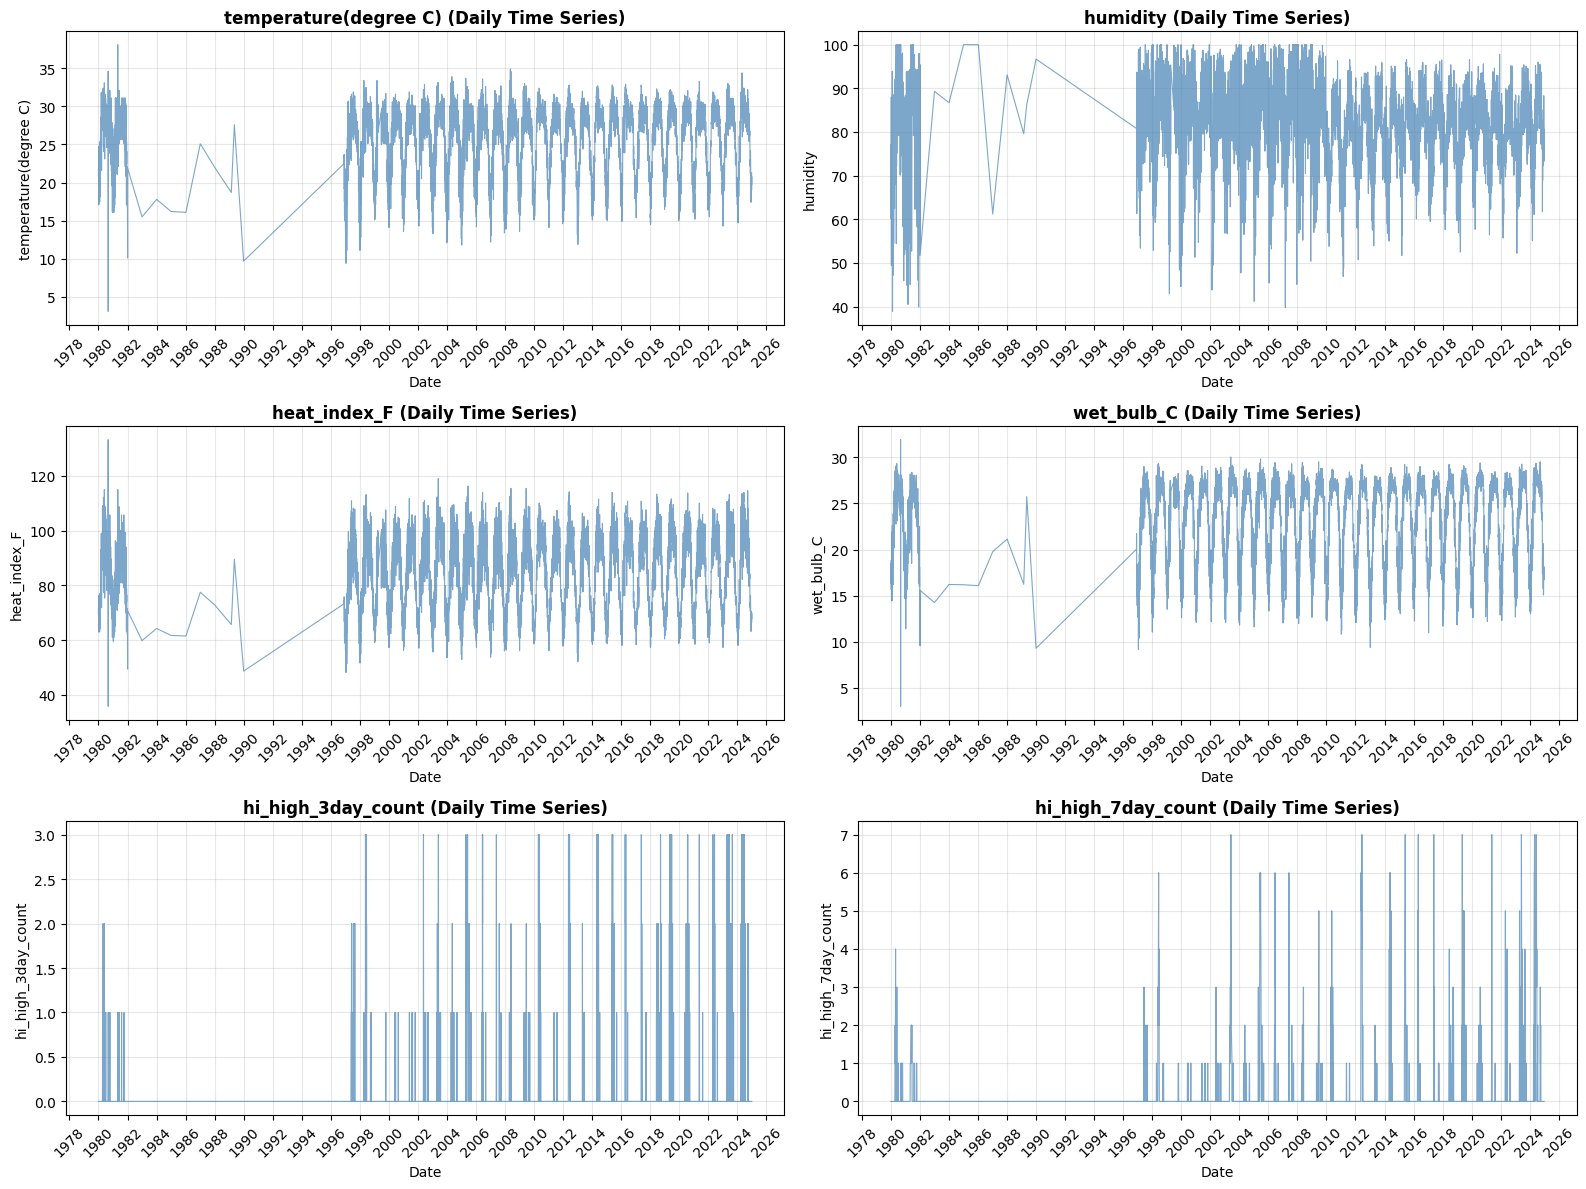


=== MONTHLY AGGREGATION (Mean values) ===
            temperature(degree C)   humidity  heat_index_F  wet_bulb_C  \
month_name                                                               
1980-01                 21.756000  66.740000     71.113660   17.448798   
1980-02                 22.630769  69.207692     73.201833   18.573983   
1980-03                 27.180769  74.846154     85.959966   23.635544   
1980-04                 29.974074  77.011111     98.178857   26.627403   
1980-05                 29.215385  81.419231     96.427055   26.536472   
1980-06                 27.872000  89.020000     91.984940   26.352981   
1980-07                 27.703448  90.517241     90.948695   26.415204   
1980-08                 27.611538  88.680769     90.085877   26.054760   
1980-09                 27.365517  87.193103     91.060311   25.582762   
1980-10                 27.526923  81.103846     88.228849   24.873077   
1980-11                 25.582143  72.932143     80.283408   21.81827

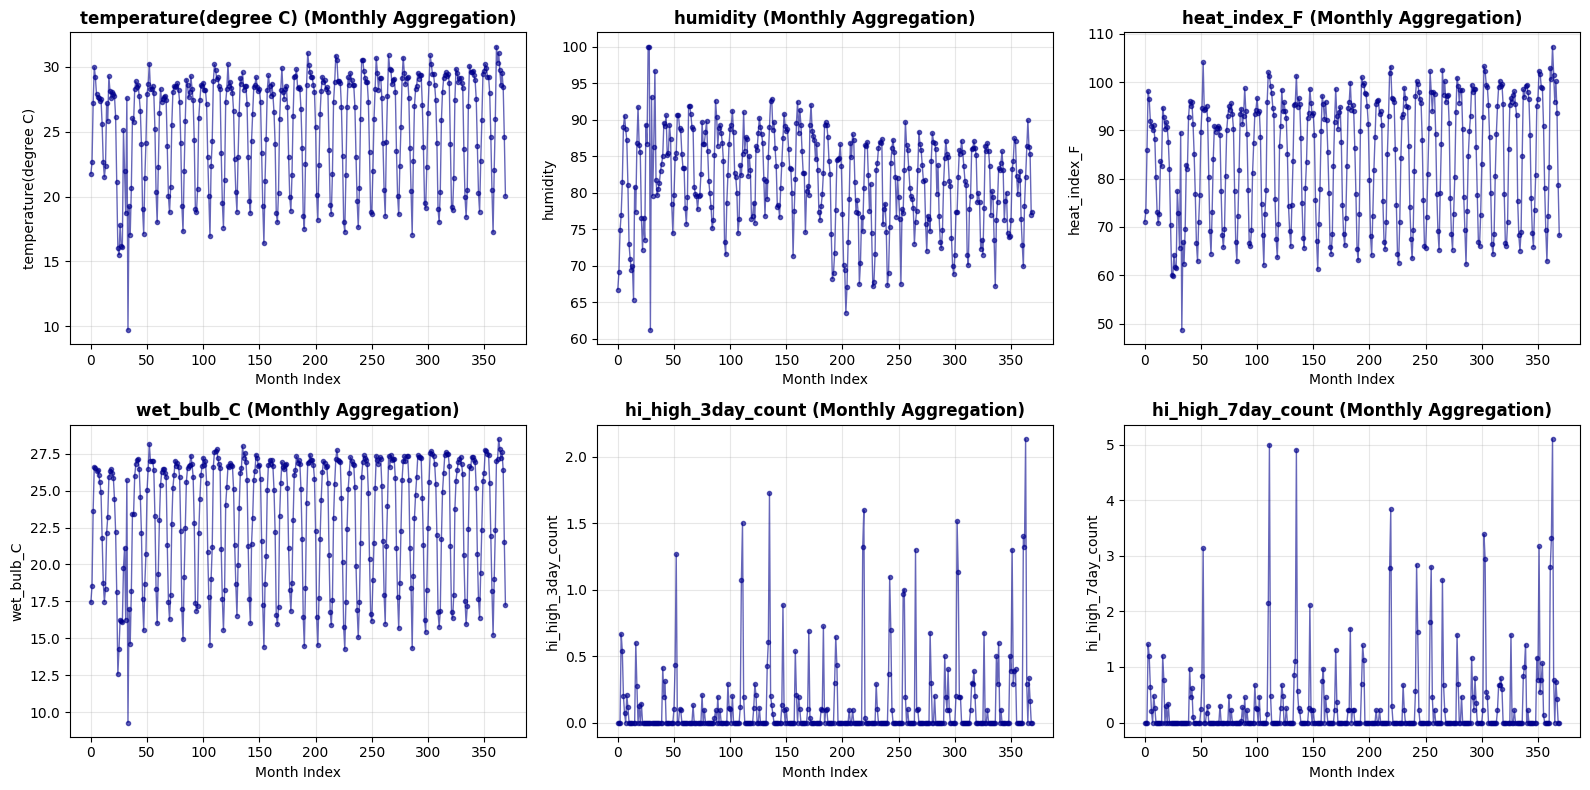


=== YEARLY PATTERN ANALYSIS ===


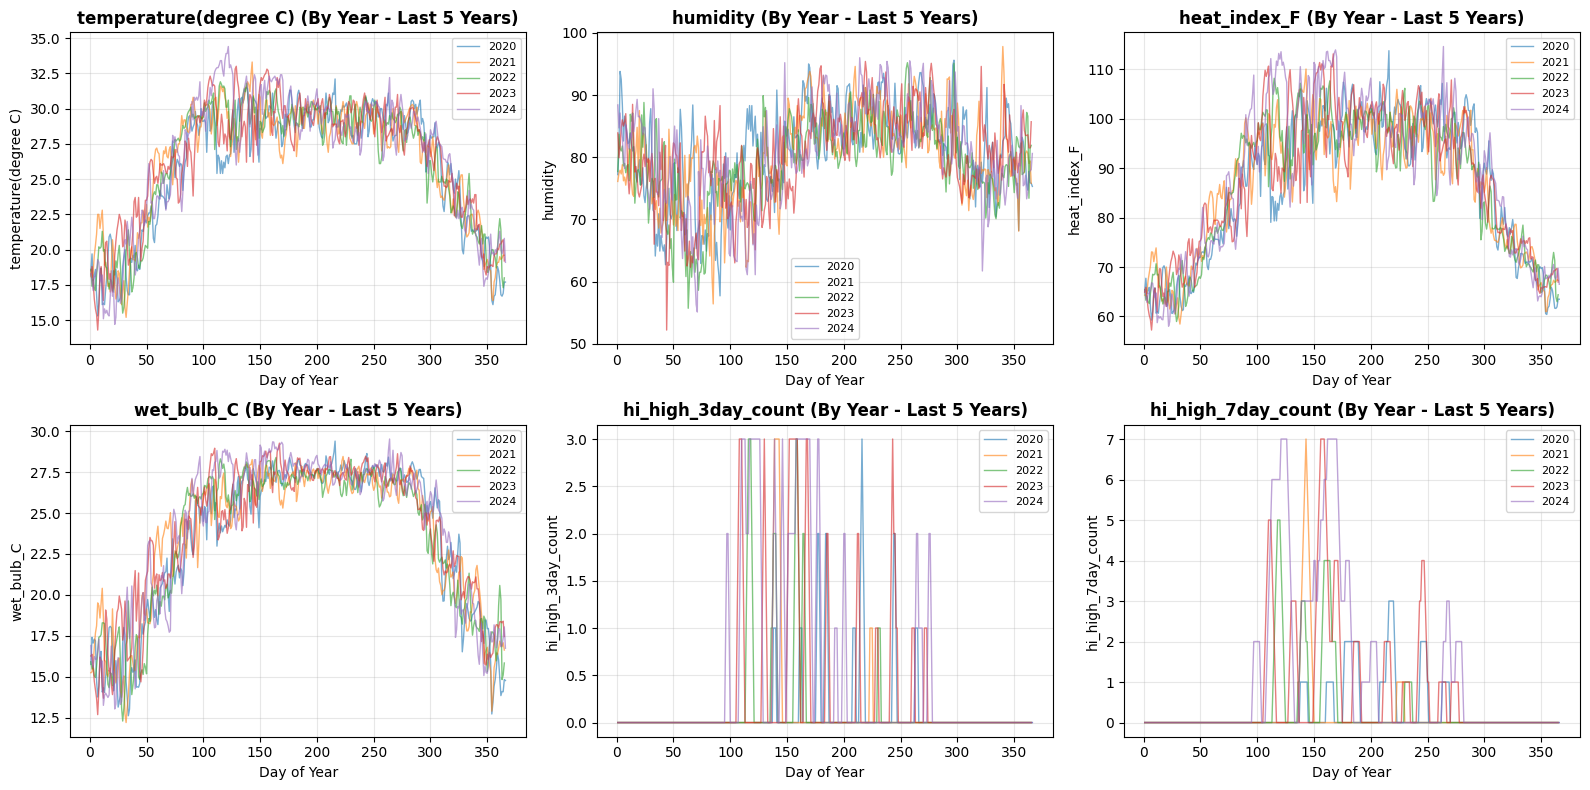


=== SEASONALITY CHECK (Mean by month across all years) ===
      temperature(degree C)   humidity  heat_index_F  wet_bulb_C  \
date                                                               
1                 18.223279  78.859672     64.689515   15.658146   
2                 21.884982  74.041880     71.887760   18.549901   
3                 26.302584  73.194382     82.775386   22.582583   
4                 28.882388  76.718913     93.103172   25.533922   
5                 29.510496  79.813610     97.044608   26.593326   
6                 29.293883  85.486017     98.237803   27.236520   
7                 28.731159  88.109899     96.070399   27.079616   
8                 28.734358  87.656751     95.970784   27.019750   
9                 28.568421  87.576545     95.092224   26.843887   
10                27.501357  85.437783     89.293730   25.496986   
11                23.956928  80.977483     76.738011   21.445107   
12                19.747926  80.870742     67.807070   1

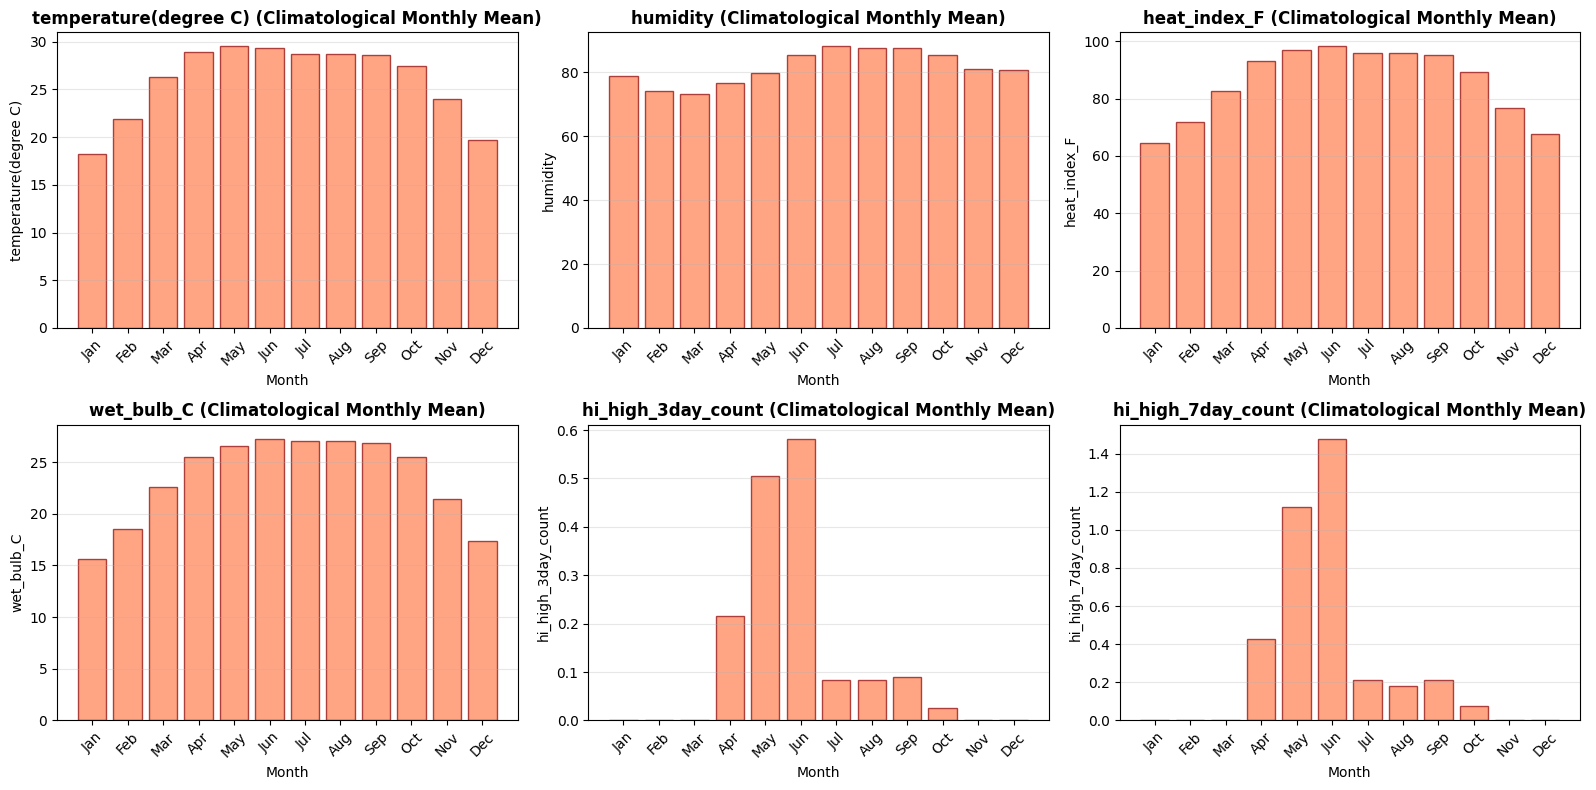


=== AUTOCORRELATION ANALYSIS ===


AttributeError: Line2D.set() got an unexpected keyword argument 'lags'

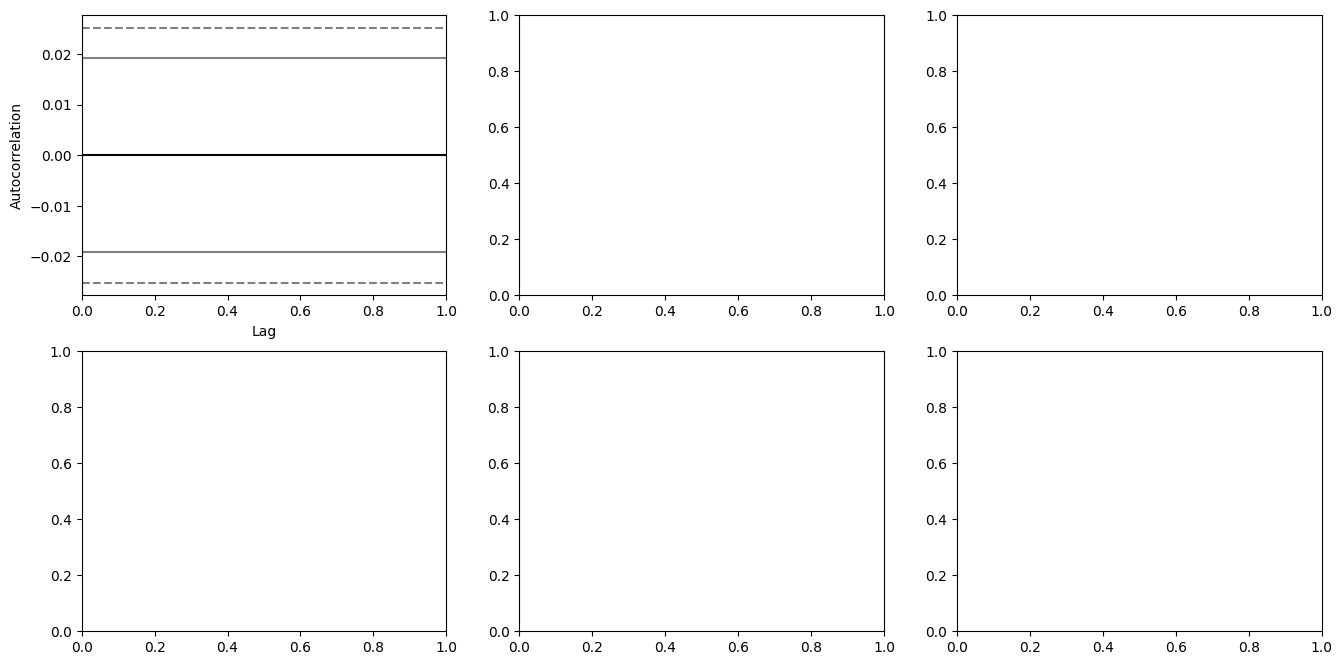

In [21]:
# --- PLOT FEATURES FOR PERIODICITY CHECK ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure df has all required features
features_to_plot = [
    'temperature(degree C)',
    'humidity',
    'heat_index_F',
    'wet_bulb_C',
    'hi_high_3day_count',
    'hi_high_7day_count'
]

# Create subplots (3 rows x 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    ax.plot(df['date'], df[feature], linewidth=0.8, color='steelblue', alpha=0.7)
    ax.set_title(f'{feature} (Daily Time Series)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel(feature)
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(2))  # Show every 2 years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# --- MONTHLY AGGREGATION (to see seasonal periodicity) ---
print("\n=== MONTHLY AGGREGATION (Mean values) ===")
df['month_name'] = df['date'].dt.strftime('%Y-%m')
monthly_agg = df.groupby('month_name')[features_to_plot].mean()
print(monthly_agg.head(12))

# --- PLOT MONTHLY PATTERNS (shows seasonality) ---
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    # Extract year-month for x-axis
    monthly_data = df.groupby(df['date'].dt.to_period('M'))[feature].mean()
    ax.plot(range(len(monthly_data)), monthly_data.values, marker='o', markersize=3, 
            linewidth=1, color='darkblue', alpha=0.6, label='Monthly mean')
    ax.set_title(f'{feature} (Monthly Aggregation)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Month Index')
    ax.set_ylabel(feature)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- YEARLY PATTERN (shows if same pattern repeats each year) ---
print("\n=== YEARLY PATTERN ANALYSIS ===")
df['year'] = df['date'].dt.year
df['day_of_year'] = df['date'].dt.dayofyear

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Plot each year separately
    for year in df['year'].unique()[-5:]:  # Plot last 5 years only
        year_data = df[df['year'] == year].sort_values('day_of_year')
        ax.plot(year_data['day_of_year'], year_data[feature], 
                label=f'{year}', alpha=0.6, linewidth=1)
    
    ax.set_title(f'{feature} (By Year - Last 5 Years)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Day of Year')
    ax.set_ylabel(feature)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- SEASONALITY CHECK (Monthly climatology across all years) ---
print("\n=== SEASONALITY CHECK (Mean by month across all years) ===")
monthly_clim = df.groupby(df['date'].dt.month)[features_to_plot].mean()
print(monthly_clim)

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    ax.bar(range(1, 13), monthly_clim[feature].values, color='coral', alpha=0.7, edgecolor='darkred')
    ax.set_title(f'{feature} (Climatological Monthly Mean)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel(feature)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(months, rotation=45)
    ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# --- AUTOCORRELATION CHECK (for time-series dependency) ---
print("\n=== AUTOCORRELATION ANALYSIS ===")
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    autocorrelation_plot(df[feature].dropna(), lags=365, ax=ax)
    ax.set_title(f'{feature} (Autocorrelation - 365 lags)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Lag (days)')

plt.tight_layout()
plt.show()

print("\n✅ Feature periodicity analysis complete!")
print("✓ Daily patterns = trend/noise in daily time series")
print("✓ Monthly patterns = seasonality visibility")
print("✓ Yearly patterns = consistency across years")
print("✓ Autocorrelation = strength of time-series dependency")

<h1>Time Series Analysis 

Date range: 1980-01-01 to 2024-12-31


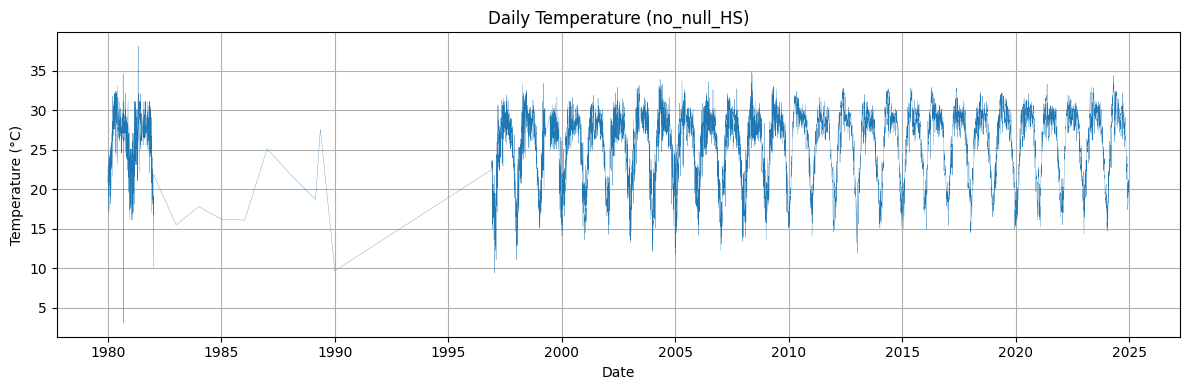

C:\Users\User\AppData\Local\Temp\ipykernel_2616\2351236412.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = no_null_HS.set_index('date')['temperature(degree C)'].resample('M').mean()


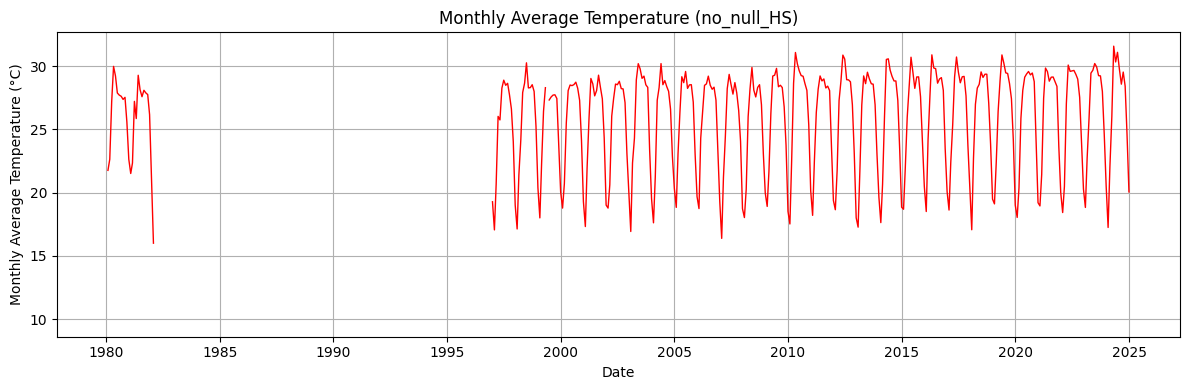

In [22]:
import matplotlib.pyplot as plt

# ensure a datetime column exists
if 'date' not in no_null_HS.columns:
    no_null_HS['date'] = pd.to_datetime(no_null_HS[['year', 'month', 'day']])

# show date range
min_date = no_null_HS['date'].min()
max_date = no_null_HS['date'].max()
print(f"Date range: {min_date.date()} to {max_date.date()}")

# plot daily temperature time series
plt.figure(figsize=(12, 4))
plt.plot(no_null_HS['date'], no_null_HS['temperature(degree C)'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Daily Temperature (no_null_HS)')
plt.grid(True)
plt.tight_layout()
plt.show()

# plot monthly average temperature to show trend
monthly_avg = no_null_HS.set_index('date')['temperature(degree C)'].resample('M').mean()
plt.figure(figsize=(12, 4))
plt.plot(monthly_avg.index, monthly_avg.values, color='red', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Monthly Average Temperature (°C)')
plt.title('Monthly Average Temperature (no_null_HS)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
no_null_HS.head()

,day,month,year,temperature(degree C),humidity,date
0,1,1,1980,21.7,77.1,1980-01-01
1,2,1,1980,20.8,64.4,1980-01-02
2,3,1,1980,23.0,60.2,1980-01-03
3,4,1,1980,22.3,70.4,1980-01-04
4,5,1,1980,22.1,67.8,1980-01-05


# Random Forest for Heat Stroke

In [23]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ===== SETUP (using df with all features already calculated) =====
# Expect a DataFrame named `df` (from feature engineering cell)

Features = model_features  # ['heat_index_F', 'wet_bulb_C', 'hi_high_3day_count', 'month', 'temp_change']
TARGET = "heatstroke_risk_prob"
DROP_COLS = ["date"]  # drop datetime

# Build X, y
X = df[Features]
y = df[TARGET].astype(float)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# ===== RANDOM FOREST FOR HEATSTROKE RISK =====
rf_hs = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_hs.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_hs.predict(X_test)

# Metrics
rf_hs_r2  = r2_score(y_test, y_pred_rf)
rf_hs_mse = mean_squared_error(y_test, y_pred_rf)
rf_hs_rmse = np.sqrt(rf_hs_mse)

def within_tolerance_acc(y_true, y_hat, tol):
    return float((np.abs(y_true - y_hat) <= tol).mean())

# Tolerance in probability units (0-1)
rf_hs_acc_05 = within_tolerance_acc(y_test.values, y_pred_rf, 0.5)
rf_hs_acc_10 = within_tolerance_acc(y_test.values, y_pred_rf, 1.0)
rf_hs_acc_20 = within_tolerance_acc(y_test.values, y_pred_rf, 2.0)
rf_hs_acc_30 = within_tolerance_acc(y_test.values, y_pred_rf, 3.0)

print("=" * 80)
print("==== RandomForest Heatstroke Risk Regression Metrics (Test) ====")
print("=" * 80)
print(f"R²  : {rf_hs_r2:.4f}")
print(f"MSE : {rf_hs_mse:.6f}")
print(f"RMSE: {rf_hs_rmse:.6f}")
print("\nAccuracy (|error| ≤ tolerance in probability):")
print(f"  ±0.5 : {rf_hs_acc_05*100:.2f}%")
print(f"  ±1.0 : {rf_hs_acc_10*100:.2f}%")
print(f"  ±2.0 : {rf_hs_acc_20*100:.2f}%")
print(f"  ±3.0 : {rf_hs_acc_30*100:.2f}%")

# ===== 5-FOLD CROSS-VALIDATION =====
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_rf = cross_val_score(rf_hs, X, y, cv=cv, scoring="r2", n_jobs=-1)
print("\n" + "=" * 80)
print("==== 5-Fold CV R² ====")
print("=" * 80)
print(f"Mean R²: {cv_r2_rf.mean():.4f}  |  Std: {cv_r2_rf.std():.4f}")

# ===== FEATURE IMPORTANCES =====
fi_rf = pd.DataFrame({
    "feature": X.columns,
    "importance": rf_hs.feature_importances_
}).sort_values("importance", ascending=False)

print("\n" + "=" * 80)
print("==== Feature Importances (RandomForest) ====")
print("=" * 80)
print(fi_rf.to_string(index=False))



==== RandomForest Heatstroke Risk Regression Metrics (Test) ====
R²  : 0.9990
MSE : 0.000030
RMSE: 0.005461

Accuracy (|error| ≤ tolerance in probability):
  ±0.5 : 100.00%
  ±1.0 : 100.00%
  ±2.0 : 100.00%
  ±3.0 : 100.00%

==== 5-Fold CV R² ====
Mean R²: 0.9997  |  Std: 0.0004

==== Feature Importances (RandomForest) ====
           feature   importance
      heat_index_F 9.856485e-01
hi_high_3day_count 1.431080e-02
        wet_bulb_C 4.072545e-05
       temp_change 3.649990e-15
             month 2.189040e-16


# predicting next 365 days HI for RF

In [24]:
import pandas as pd
import numpy as np

# --- Inputs ---
df = df.copy()  # your original DataFrame with all features already calculated
TARGET = "heatstroke_risk_prob"

# Sort by date
df = df.sort_values("date").reset_index(drop=True)

# 1) Create next 365 dates
last_date = df["date"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=365, freq="D")
future_df = pd.DataFrame({"date": future_dates})
future_df["year"] = future_df["date"].dt.year
future_df["month"] = future_df["date"].dt.month
future_df["day"] = future_df["date"].dt.day

# 2) Build monthly-day climatology from historical data (T, RH only)
hist = df.copy()
hist["month"] = hist["date"].dt.month
hist["day"] = hist["date"].dt.day

clim = (
    hist.groupby(["month", "day"])[[temp_col, hum_col]]
    .mean()
    .reset_index()
    .rename(columns={temp_col: f"{temp_col}_clim", hum_col: f"{hum_col}_clim"})
)

# Merge climatology into future calendar
future_with_clim = future_df.merge(clim, on=["month", "day"], how="left")

# 3) Fallback for missing climatology values: use recent rolling mean (last 7 days)
recent_window = 7
recent_mean_temp = (
    hist[temp_col].tail(recent_window).mean() if not hist.empty else np.nan
)
recent_mean_hum = (
    hist[hum_col].tail(recent_window).mean() if not hist.empty else np.nan
)

# Fill missing climatology with recent means
future_with_clim[temp_col] = future_with_clim[f"{temp_col}_clim"].fillna(recent_mean_temp)
future_with_clim[hum_col]  = future_with_clim[f"{hum_col}_clim"].fillna(recent_mean_hum)

# 4) Calculate DERIVED FEATURES (HI, Tw, duration) for future data
def prepare_future_features(future_data):
    """Calculate HI, Tw, duration features for future dates."""
    # Heat Index
    future_data['heat_index_C'] = future_data.apply(
        lambda r: calculate_heat_index(r[temp_col], r[hum_col]), axis=1)
    future_data['heat_index_F'] = future_data['heat_index_C'] * 9.0/5.0 + 32.0
    
    # Wet-Bulb Temperature
    future_data['wet_bulb_C'] = future_data.apply(
        lambda r: wet_bulb_temp_C(r[temp_col], r[hum_col]), axis=1)
    
    # Duration features (rolling count of high HI days)
    future_data['hi_high_flag'] = (future_data['heat_index_F'] >= 105.0).astype(int)
    future_data['hi_high_3day_count'] = future_data['hi_high_flag'].rolling(window=3, min_periods=1).sum()
    
    # Temperature trend
    future_data['temp_change'] = future_data[temp_col].diff().fillna(0)
    
    return future_data

future_with_clim = prepare_future_features(future_with_clim)

# 5) Keep only the DERIVED features expected by the model
X_future = future_with_clim[model_features].copy()
 #model_features = ['heat_index_F', 'wet_bulb_C', 'hi_high_3day_count', 'month', 'temp_change']

# 6) Predict using your trained RF_HS model
future_pred_rf = rf_hs.predict(X_future)

# 7) Output DataFrame
rf_hs_forecast_out = future_with_clim[["date", "year", "month", "day"]].copy()
rf_hs_forecast_out["pred_heatstroke_risk_prob"] = future_pred_rf
rf_hs_forecast_out[temp_col] = future_with_clim[temp_col].values
rf_hs_forecast_out[hum_col] = future_with_clim[hum_col].values
rf_hs_forecast_out["heat_index_F"] = future_with_clim["heat_index_F"].values
rf_hs_forecast_out["wet_bulb_C"] = future_with_clim["wet_bulb_C"].values

print("=" * 80)
print("==== 365-Day Heatstroke Risk Forecast (RandomForest) ====")
print("=" * 80)
print(rf_hs_forecast_out.head(10))

# --- CATEGORIZE FORECAST SEVERITY ---
def categorize_forecast_severity(risk_prob):
    """Convert probability to severity category."""
    if risk_prob >= 0.85:
        return 'Extreme Danger'
    elif risk_prob >= 0.60:
        return 'Danger'
    elif risk_prob >= 0.35:
        return 'Extreme Caution'
    elif risk_prob >= 0.15:
        return 'Caution'
    else:
        return 'Comfortable'

rf_hs_forecast_out['forecast_severity'] = rf_hs_forecast_out['pred_heatstroke_risk_prob'].apply(categorize_forecast_severity)

print("\n📊 Severity Distribution (365-day forecast):")
print(rf_hs_forecast_out['forecast_severity'].value_counts())



==== 365-Day Heatstroke Risk Forecast (RandomForest) ====
        date  year  month  day  pred_heatstroke_risk_prob  \
0 2025-01-01  2025      1    1                       0.05   
1 2025-01-02  2025      1    2                       0.05   
2 2025-01-03  2025      1    3                       0.05   
3 2025-01-04  2025      1    4                       0.05   
4 2025-01-05  2025      1    5                       0.05   
5 2025-01-06  2025      1    6                       0.05   
6 2025-01-07  2025      1    7                       0.05   
7 2025-01-08  2025      1    8                       0.05   
8 2025-01-09  2025      1    9                       0.05   
9 2025-01-10  2025      1   10                       0.05   

   temperature(degree C)   humidity  heat_index_F  wet_bulb_C  
0              18.087500  80.953125     64.518047   15.806801  
1              18.325806  80.890323     64.986942   16.028662  
2              18.157576  81.527273     64.683782   15.942806  
3             

<h1>XG BOOST MODEL for heatstroke risk prediction

In [25]:
# ...existing code...
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

# NOTE: run this cell after your feature-engineering cells (prepare_future_features must exist)
df_hs = df.copy()

FEATURES = model_features
TARGET = "heatstroke_risk_prob"
DROP_COLS = ["date"]

X = df_hs[FEATURES]
y = df_hs[TARGET].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

xgb_hs = xgb.XGBRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)
xgb_hs.fit(X_train, y_train)

y_pred = xgb_hs.predict(X_test)

xgb_hs_r2  = r2_score(y_test, y_pred)
xgb_hs_mse = mean_squared_error(y_test, y_pred)
xgb_hs_rmse = np.sqrt(xgb_hs_mse)

def within_tolerance_acc(y_true, y_hat, tol):
    return float((np.abs(y_true - y_hat) <= tol).mean())

xgb_hs_acc_05 = within_tolerance_acc(y_test.values, y_pred, 0.5)
xgb_hs_acc_10 = within_tolerance_acc(y_test.values, y_pred, 1.0)
xgb_hs_acc_20 = within_tolerance_acc(y_test.values, y_pred, 2.0)
xgb_hs_acc_30 = within_tolerance_acc(y_test.values, y_pred, 3.0)

print("="*80)
print("==== XGBoost Heatstroke Risk Regression Metrics (Test) ====")
print("="*80)
print(f"R^2  : {xgb_hs_r2:.4f}")
print(f"MSE  : {xgb_hs_mse:.6f}")
print(f"RMSE : {xgb_hs_rmse:.6f}")
print("\nAccuracy (|error| ≤ tolerance in probability units):")
print(f"  ±0.5 : {xgb_hs_acc_05*100:.2f}%")
print(f"  ±1.0 : {xgb_hs_acc_10*100:.2f}%")
print(f"  ±2.0 : {xgb_hs_acc_20*100:.2f}%")
print(f"  ±3.0 : {xgb_hs_acc_30*100:.2f}%")

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(xgb_hs, X, y, cv=cv, scoring="r2", n_jobs=-1)
print("\n==== 5-Fold CV R^2 ====")
print(f"Mean xgb_hs_R^2 : {cv_r2.mean():.4f}  |  Std : {cv_r2.std():.4f}")

fi = pd.DataFrame({
    "feature": X.columns,
    "importance": xgb_hs.feature_importances_
}).sort_values("importance", ascending=False)

print("\n==== Feature Importances (XGBoost - Heatstroke) ====")
print(fi.to_string(index=False))

# Optional 365-day forecast (requires prepare_future_features defined earlier)
last_date = df_hs["date"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=365, freq="D")
future_df = pd.DataFrame({"date": future_dates})
future_df["year"] = future_df["date"].dt.year
future_df["month"] = future_df["date"].dt.month
future_df["day"] = future_df["date"].dt.day

hist = df_hs.copy()
hist["month"] = hist["date"].dt.month
hist["day"] = hist["date"].dt.day
clim = (
    hist.groupby(["month", "day"])[[temp_col, hum_col]]
    .mean()
    .reset_index()
    .rename(columns={temp_col: f"{temp_col}_clim", hum_col: f"{hum_col}_clim"})
)
future_with_clim = future_df.merge(clim, on=["month", "day"], how="left")

recent_window = 7
recent_mean_temp = hist[temp_col].tail(recent_window).mean()
recent_mean_hum  = hist[hum_col].tail(recent_window).mean()

future_with_clim[temp_col] = future_with_clim[f"{temp_col}_clim"].fillna(recent_mean_temp)
future_with_clim[hum_col]  = future_with_clim[f"{hum_col}_clim"].fillna(recent_mean_hum)

future_with_clim = prepare_future_features(future_with_clim)

X_future = future_with_clim[FEATURES].copy()
future_pred = xgb_hs.predict(X_future)

xgb_hs_forecast_out = future_with_clim[["date", "year", "month", "day"]].copy()
xgb_hs_forecast_out["pred_heatstroke_risk_prob"] = future_pred
xgb_hs_forecast_out[temp_col] = future_with_clim[temp_col].values
xgb_hs_forecast_out[hum_col] = future_with_clim[hum_col].values
xgb_hs_forecast_out["heat_index_F"] = future_with_clim["heat_index_F"].values
xgb_hs_forecast_out["wet_bulb_C"] = future_with_clim["wet_bulb_C"].values

print("\n==== 365-Day Heatstroke Risk Forecast (XGBoost) ====")
print(xgb_hs_forecast_out.head(10))

xgb_hs_forecast_out['forecast_severity'] = xgb_hs_forecast_out['pred_heatstroke_risk_prob'].apply(categorize_forecast_severity)
print("\n📊 Severity Distribution (365-day XGBoost forecast):")
print(xgb_hs_forecast_out['forecast_severity'].value_counts())
# ...existing code...

==== XGBoost Heatstroke Risk Regression Metrics (Test) ====
R^2  : 0.9974
MSE  : 0.000075
RMSE : 0.008647

Accuracy (|error| ≤ tolerance in probability units):
  ±0.5 : 100.00%
  ±1.0 : 100.00%
  ±2.0 : 100.00%
  ±3.0 : 100.00%

==== 5-Fold CV R^2 ====
Mean xgb_hs_R^2 : 0.9974  |  Std : 0.0006

==== Feature Importances (XGBoost - Heatstroke) ====
           feature  importance
      heat_index_F    0.960076
hi_high_3day_count    0.037859
        wet_bulb_C    0.001144
             month    0.000469
       temp_change    0.000451

==== 365-Day Heatstroke Risk Forecast (XGBoost) ====
        date  year  month  day  pred_heatstroke_risk_prob  \
0 2025-01-01  2025      1    1                   0.050079   
1 2025-01-02  2025      1    2                   0.050079   
2 2025-01-03  2025      1    3                   0.050079   
3 2025-01-04  2025      1    4                   0.050079   
4 2025-01-05  2025      1    5                   0.050079   
5 2025-01-06  2025      1    6               

<h1>Predicting nect 365 days using XGboost

In [26]:
# ...existing code...
import pandas as pd
import numpy as np

# --- Inputs ---
df_hs = df.copy()  # your engineered heatstroke dataset
TARGET = "heatstroke_risk_prob"

# Sort by date
df_hs = df_hs.sort_values("date").reset_index(drop=True)

# 1) Create next 365 dates
last_date = df_hs["date"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=365, freq="D")
future_df = pd.DataFrame({"date": future_dates})
future_df["year"] = future_df["date"].dt.year
future_df["month"] = future_df["date"].dt.month
future_df["day"] = future_df["date"].dt.day

# 2) Build monthly-day climatology from historical data
hist = df_hs.copy()
hist["month"] = hist["date"].dt.month
hist["day"] = hist["date"].dt.day

clim = (
    hist.groupby(["month", "day"])[[temp_col, hum_col]]
    .mean()
    .reset_index()
    .rename(columns={temp_col: f"{temp_col}_clim", hum_col: f"{hum_col}_clim"})
)
# ...existing code...
# Merge climatology into future calendar (ensure `clim` was built earlier)
future_with_clim = future_df.merge(clim, on=["month", "day"], how="left")

# 3) Fallback for missing climatology values: use recent rolling mean (last 7 days)
recent_window = 7
recent_mean_temp = hist[temp_col].tail(recent_window).mean() if not hist.empty else np.nan
recent_mean_hum  = hist[hum_col].tail(recent_window).mean() if not hist.empty else np.nan

# Fill missing climatology with recent means (use f-strings so column names match)
future_with_clim[temp_col] = future_with_clim[f"{temp_col}_clim"].fillna(recent_mean_temp)
future_with_clim[hum_col]  = future_with_clim[f"{hum_col}_clim"].fillna(recent_mean_hum)

# 4) Calculate DERIVED FEATURES (HI, Tw, duration) for future data
# (ensure prepare_future_features() is defined earlier in the notebook)
future_with_clim = prepare_future_features(future_with_clim)

# 5) Select the exact features the model was trained on (names & order must match)
# model_features should be: ['heat_index_F','wet_bulb_C','hi_high_3day_count','month','temp_change']
X_future = future_with_clim[model_features].copy()

# Ensure numeric dtypes and handle any remaining NaNs
X_future = X_future.apply(pd.to_numeric, errors="coerce")
# fill NaNs with column mean then 0 as final fallback
X_future = X_future.fillna(X_future.mean()).fillna(0.0)

# 6) Predict using the trained XGBoost model (xgb_hs must be trained earlier)
future_pred = xgb_hs.predict(X_future)

# 7) Output DataFrame (include useful derived cols for inspection)
xgb_hs_forecast_out = future_with_clim[["date", "year", "month", "day"]].copy()
xgb_hs_forecast_out["pred_heatstroke_risk_prob"] = future_pred
xgb_hs_forecast_out[temp_col] = future_with_clim[temp_col].values
xgb_hs_forecast_out[hum_col]  = future_with_clim[hum_col].values
xgb_hs_forecast_out["heat_index_F"] = future_with_clim["heat_index_F"].values
xgb_hs_forecast_out["wet_bulb_C"]  = future_with_clim["wet_bulb_C"].values

print("==== 365-step Heatstroke Forecast (XGBoost with derived features) ====")
print(xgb_hs_forecast_out.head(20))
# ...existing code...

==== 365-step Heatstroke Forecast (XGBoost with derived features) ====
         date  year  month  day  pred_heatstroke_risk_prob  \
0  2025-01-01  2025      1    1                   0.050079   
1  2025-01-02  2025      1    2                   0.050079   
2  2025-01-03  2025      1    3                   0.050079   
3  2025-01-04  2025      1    4                   0.050079   
4  2025-01-05  2025      1    5                   0.050079   
5  2025-01-06  2025      1    6                   0.050079   
6  2025-01-07  2025      1    7                   0.050079   
7  2025-01-08  2025      1    8                   0.050079   
8  2025-01-09  2025      1    9                   0.050079   
9  2025-01-10  2025      1   10                   0.050079   
10 2025-01-11  2025      1   11                   0.050079   
11 2025-01-12  2025      1   12                   0.050079   
12 2025-01-13  2025      1   13                   0.050079   
13 2025-01-14  2025      1   14                   0.050079   

<h1>LIghtGBM model for heatstroke risk prediction

In [27]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

df_hs = df.copy()

FEATURES = model_features
TARGET = "heatstroke_risk_prob"
DROP_COLS = ["date"]

X = df_hs[FEATURES]
y = df_hs[TARGET].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

lgb_hs = lgb.LGBMRegressor(
    n_estimators=150,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)
lgb_hs.fit(X_train, y_train)

y_pred = lgb_hs.predict(X_test)

lgb_hs_r2 = r2_score(y_test, y_pred)
lgb_hs_mse = mean_squared_error(y_test, y_pred)
lgb_hs_rmse = np.sqrt(lgb_hs_mse)

def within_tolerance_acc(y_true, y_hat, tol):
    return float((np.abs(y_true - y_hat) <= tol).mean())

lgb_hs_acc_005 = within_tolerance_acc(y_test.values, y_pred, 0.05)
lgb_hs_acc_010 = within_tolerance_acc(y_test.values, y_pred, 0.10)
lgb_hs_acc_020 = within_tolerance_acc(y_test.values, y_pred, 0.20)
lgb_hs_acc_030 = within_tolerance_acc(y_test.values, y_pred, 0.30)

print("==== LightGBM Heatstroke Metrics (Test) ====")
print(f"lgb_R^2  : {lgb_hs_r2:.4f}")
print(f"lgb_MSE  : {lgb_hs_mse:.6f}")
print(f"lgb_RMSE : {lgb_hs_rmse:.6f}")
print("Accuracy (|error| ≤ tolerance):")
print(f"  ±0.05 : {lgb_hs_acc_005*100:.2f}%")
print(f"  ±0.10 : {lgb_hs_acc_010*100:.2f}%")
print(f"  ±0.20 : {lgb_hs_acc_020*100:.2f}%")
print(f"  ±0.30 : {lgb_hs_acc_030*100:.2f}%")

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(lgb_hs, X, y, cv=cv, scoring="r2", n_jobs=-1)
print("\n==== 5-Fold CV lgb_R^2 ====")
print(f"Mean lgb_R^2 : {cv_r2.mean():.4f}  |  Std : {cv_r2.std():.4f}")

fi = pd.DataFrame({
    "feature": X.columns,
    "importance": lgb_hs.feature_importances_
}).sort_values("importance", ascending=False)

print("\n==== Top 20 Feature Importances ====")
print(fi.head(20).to_string(index=False))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 8382, number of used features: 5
[LightGBM] [Info] Start training from score 0.223166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
==== LightGBM Heatstroke Metrics (Test) ====
lgb_R^2  : 0.9978
lgb_MSE  : 0.000065
lgb_RMSE : 0.008088
Accuracy (|error| ≤ tolerance):
  ±0.05 : 99.67%
  ±0.10 : 99.90%
  ±0.20 : 99.95%
  ±0.30 : 100.00%

==== 5-Fold CV lgb_R^2 ====
Mean lgb_R^2 : 0.9964  |  Std : 0.0016

==== Top 20 Feature Importances ====
           feature  importance
      heat_index_F        1612
       temp_change        1262
        wet_bulb_C         997
hi_high_3day_count         400
             month         213


<h1>Predicting next 365 days using LightGBM

In [28]:
import pandas as pd
import numpy as np

# --- Inputs ---
df_hs = df.copy()  # your engineered heatstroke dataset
TARGET = "heatstroke_risk_prob"

# Sort by date
df_hs = df_hs.sort_values("date").reset_index(drop=True)

# 1) Create next 365 dates
last_date = df_hs["date"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=365, freq="D")
future_df = pd.DataFrame({"date": future_dates})
future_df["year"] = future_df["date"].dt.year
future_df["month"] = future_df["date"].dt.month
future_df["day"] = future_df["date"].dt.day

# 2) Build monthly-day climatology from historical data
hist = df_hs.copy()
hist["month"] = hist["date"].dt.month
hist["day"] = hist["date"].dt.day

clim = (
    hist.groupby(["month", "day"])[[temp_col, hum_col]]
    .mean()
    .reset_index()
    .rename(columns={temp_col: f"{temp_col}_clim", hum_col: f"{hum_col}_clim"})
)

# Merge climatology into future calendar
future_with_clim = future_df.merge(clim, on=["month", "day"], how="left")

# 3) Fallback for missing climatology values: use recent rolling mean (last 7 days)
recent_window = 7
recent_mean_temp = (
    hist[temp_col].tail(recent_window).mean() if not hist.empty else np.nan
)
recent_mean_hum = (
    hist[hum_col].tail(recent_window).mean() if not hist.empty else np.nan
)

# Fill missing climatology with recent means
future_with_clim[temp_col] = future_with_clim[f"{temp_col}_clim"].fillna(recent_mean_temp)
future_with_clim[hum_col]  = future_with_clim[f"{hum_col}_clim"].fillna(recent_mean_hum)

# 4) Calculate DERIVED FEATURES (HI, Tw, duration) for future data
# (uses prepare_future_features() defined earlier)
future_with_clim = prepare_future_features(future_with_clim)

# 5) Select the exact features the model was trained on
X_future = future_with_clim[model_features].copy()

# Ensure numeric dtypes and handle any remaining NaNs
X_future = X_future.apply(pd.to_numeric, errors="coerce")
X_future = X_future.fillna(X_future.mean()).fillna(0.0)

# 6) Predict using the trained LightGBM model (lgb_hs, not lgb_model)
future_pred = lgb_hs.predict(X_future)

# 7) Output DataFrame
lgb_hs_forecast_out = future_with_clim[["date", "year", "month", "day"]].copy()
lgb_hs_forecast_out["pred_heatstroke_risk_prob"] = future_pred
lgb_hs_forecast_out[temp_col] = future_with_clim[temp_col].values
lgb_hs_forecast_out[hum_col]  = future_with_clim[hum_col].values
lgb_hs_forecast_out["heat_index_F"] = future_with_clim["heat_index_F"].values
lgb_hs_forecast_out["wet_bulb_C"] = future_with_clim["wet_bulb_C"].values

print("==== 365-step Heatstroke Risk Forecast (LightGBM) ====")
print(lgb_hs_forecast_out.head(20))

# Categorize severity
def categorize_forecast_severity(risk_prob):
    if risk_prob >= 0.85:
        return 'Extreme Danger'
    elif risk_prob >= 0.60:
        return 'Danger'
    elif risk_prob >= 0.35:
        return 'Extreme Caution'
    elif risk_prob >= 0.15:
        return 'Caution'
    else:
        return 'Comfortable'

lgb_hs_forecast_out['forecast_severity'] = lgb_hs_forecast_out['pred_heatstroke_risk_prob'].apply(categorize_forecast_severity)

print("\n📊 Severity Distribution (365-day LightGBM forecast):")
print(lgb_hs_forecast_out['forecast_severity'].value_counts())

==== 365-step Heatstroke Risk Forecast (LightGBM) ====
         date  year  month  day  pred_heatstroke_risk_prob  \
0  2025-01-01  2025      1    1                   0.049942   
1  2025-01-02  2025      1    2                   0.050060   
2  2025-01-03  2025      1    3                   0.050000   
3  2025-01-04  2025      1    4                   0.050068   
4  2025-01-05  2025      1    5                   0.049975   
5  2025-01-06  2025      1    6                   0.050061   
6  2025-01-07  2025      1    7                   0.049961   
7  2025-01-08  2025      1    8                   0.050000   
8  2025-01-09  2025      1    9                   0.049975   
9  2025-01-10  2025      1   10                   0.050049   
10 2025-01-11  2025      1   11                   0.050068   
11 2025-01-12  2025      1   12                   0.049975   
12 2025-01-13  2025      1   13                   0.050000   
13 2025-01-14  2025      1   14                   0.050049   
14 2025-01-15  

<h1>Show comparison between the models 

In [29]:
import pandas as pd

model_performance = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "LightGBM"],
    "R^2": [rf_hs_r2, xgb_hs_r2, lgb_hs_r2],
    "MSE": [rf_hs_mse, xgb_hs_mse, lgb_hs_mse],
    "RMSE": [rf_hs_rmse, xgb_hs_rmse, lgb_hs_rmse],
    "Acc ±0.5°C (%)": [rf_hs_acc_05*100, xgb_hs_acc_05*100, lgb_hs_acc_005*100],
    "Acc ±1.0°C (%)": [rf_hs_acc_10*100, xgb_hs_acc_10*100, lgb_hs_acc_010*100],
    "Acc ±2.0°C (%)": [rf_hs_acc_20*100, xgb_hs_acc_20*100, lgb_hs_acc_020*100],
    "Acc ±3.0°C (%)": [rf_hs_acc_30*100, xgb_hs_acc_30*100, lgb_hs_acc_030*100],
})
print("\n==== Model Performance Comparison ====")
print(model_performance.to_string(index=False))



==== Model Performance Comparison ====
        Model      R^2      MSE     RMSE  Acc ±0.5°C (%)  Acc ±1.0°C (%)  Acc ±2.0°C (%)  Acc ±3.0°C (%)
Random Forest 0.998978 0.000030 0.005461      100.000000       100.00000       100.00000           100.0
      XGBoost 0.997438 0.000075 0.008647      100.000000       100.00000       100.00000           100.0
     LightGBM 0.997759 0.000065 0.008088       99.666031        99.90458        99.95229           100.0


<h1>Selecting the best model 

In [30]:
def select_best_model(df, sort_by_metrics):
    sort_cols = [m[0] for m in sort_by_metrics]
    ascending = [not m[1] for m in sort_by_metrics]
    ranked = df.sort_values(by=sort_cols, ascending=ascending).reset_index(drop=True)
    print("\n--- Model Ranking ---")
    print(ranked[['Model'] + sort_cols].to_string(index=False))
    return ranked.iloc[0]['Model']

# Build consistent df_performance used by selection code
df_performance = model_performance.copy()

# Strategies
strategy_1 = [("RMSE", False), ("R^2", True)]
strategy_2 = [("Acc ±0.5°C (%)", True), ("MSE", False)]
strategy_3 = [("Acc ±1.0°C (%)", True), ("MSE", False)]

print("\n" + "="*60)
print("STRATEGY 1: RMSE (min) -> R^2 (max)")
best1 = select_best_model(df_performance, strategy_1)
print(f"BEST: {best1}")

print("\n" + "="*60)
print("STRATEGY 2: Acc ±0.5°C (max) -> MSE (min)")
best2 = select_best_model(df_performance, strategy_2)
print(f"BEST: {best2}")



STRATEGY 1: RMSE (min) -> R^2 (max)

--- Model Ranking ---
        Model     RMSE      R^2
Random Forest 0.005461 0.998978
     LightGBM 0.008088 0.997759
      XGBoost 0.008647 0.997438
BEST: Random Forest

STRATEGY 2: Acc ±0.5°C (max) -> MSE (min)

--- Model Ranking ---
        Model  Acc ±0.5°C (%)      MSE
Random Forest      100.000000 0.000030
      XGBoost      100.000000 0.000075
     LightGBM       99.666031 0.000065
BEST: Random Forest
